# Visualise and quantify effects of SST, z20 and surface chlorophyll variations on skipjack Tuna biomass

### Must have already completed:
* ~/Library/CloudStorage/OneDrive-CSIRO/manuscripts/Pacific_modes_oceanBGC/scripts/gam_skipjack_habitatprediction.Rmd
* transfered resulting netCDFs to Gadi at /g/data/es60/pjb581/SPC/data

### imports

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# statistics
import scipy as sci

# regridding package
import xesmf as xe

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### Load tuna biomass dataset following GAM fit

In [19]:
dat = xr.open_dataset("./data/skipjack_biomass_predictions_GAM_all.nc", decode_times=False)

# reassign time coordinate as dates, not integers
base_date = pd.Timestamp("1960-01-15")
months_since_1960 = dat.time.values.astype(int)
new_dates = [base_date + pd.DateOffset(months=int(m)) for m in months_since_1960-1]
dat = dat.assign_coords(time=new_dates)


scenarios = xr.open_dataset("./data/skipjack_biomass_scenarios_GAM_all.nc", decode_times=False)
base_date = pd.Timestamp("1960-01-15")
months_since_1960 = scenarios.time.values.astype(int)
new_dates = [base_date + pd.DateOffset(months=int(m)) for m in months_since_1960-1]
scenarios = scenarios.assign_coords(time=new_dates)
scenarios

<xarray.Dataset> Size: 88MB
Dimensions:             (lon: 120, lat: 40, time: 228)
Coordinates:
  * lon                 (lon) float64 960B 120.5 121.5 122.5 ... 238.5 239.5
  * lat                 (lat) float64 320B -19.5 -18.5 -17.5 ... 17.5 18.5 19.5
  * time                (time) datetime64[ns] 2kB 2005-01-15 ... 2023-12-15
Data variables: (12/20)
    with_CC             (time, lat, lon) float32 4MB ...
    with_CC_sst         (time, lat, lon) float32 4MB ...
    with_CC_sstlag6     (time, lat, lon) float32 4MB ...
    with_CC_z20         (time, lat, lon) float32 4MB ...
    with_CC_chl         (time, lat, lon) float32 4MB ...
    without_HF          (time, lat, lon) float32 4MB ...
    ...                  ...
    without_MF_chl      (time, lat, lon) float32 4MB ...
    without_LF          (time, lat, lon) float32 4MB ...
    without_LF_sst      (time, lat, lon) float32 4MB ...
    without_LF_sstlag6  (time, lat, lon) float32 4MB ...
    without_LF_z20      (time, lat, lon) float32 4MB ...
    without_LF_chl      (time, lat, lon) float32 4MB ...
Attributes:
    title:    GAM-predicted Biomass Scenarios
    author:   Generated with ChatGPT + R
    history:  Created on 2025-06-23

### Determine the R2 of the GAM on the SEAPODYM biomass

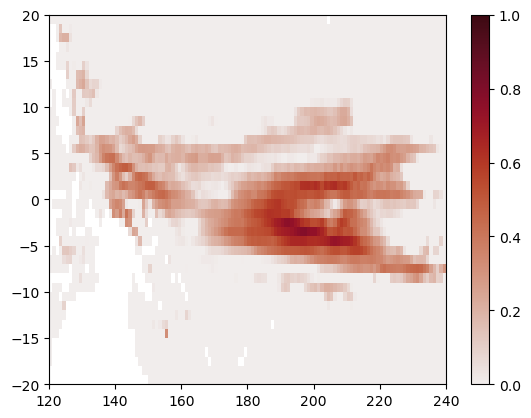

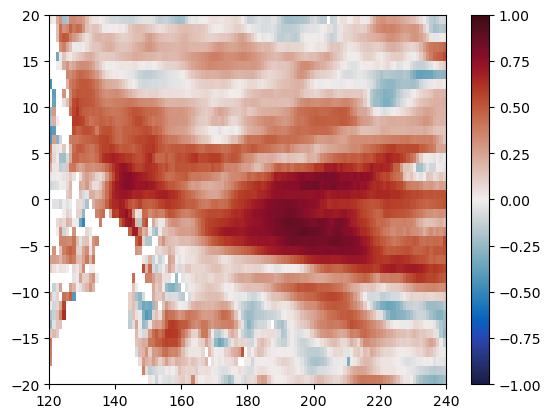

In [9]:
def r2_along_time(y_true, y_pred):
    """Compute R² score along the time dimension."""
    ss_res = ((y_true - y_pred) ** 2).sum(dim='time')
    ss_tot = ((y_true - y_true.mean(dim='time')) ** 2).sum(dim='time')
    r2 = 1 - ss_res / ss_tot
    return r2

def pearson_r_along_time(x, y):
    """Compute Pearson correlation along the 'time' dimension."""
    x_mean = x.mean(dim='time')
    y_mean = y.mean(dim='time')

    x_anom = x - x_mean
    y_anom = y - y_mean

    numerator = (x_anom * y_anom).sum(dim='time')
    denominator = (x_anom**2).sum(dim='time')**0.5 * (y_anom**2).sum(dim='time')**0.5

    r = numerator / denominator
    return r

# Example usage:
pearson_r_map = pearson_r_along_time(dat['actual_biomass'], dat['predicted_biomass'])
# Example usage:
r2_map = r2_along_time(dat['actual_biomass'], dat['predicted_biomass'])

plt.figure()
plt.pcolormesh(dat['lon'], dat['lat'], r2_map, vmin=0, vmax=1, cmap=cmo.amp)
plt.colorbar()

plt.figure()
plt.pcolormesh(dat['lon'], dat['lat'], pearson_r_map, vmin=-1, vmax=1, cmap=cmo.balance)
plt.colorbar()

### Load the environmental variables as predictors

In [101]:
sst = xr.open_dataset("./data/sst_on_tuna_grid.nc")
z20 = xr.open_dataset("./data/z20_on_tuna_grid.nc")
chl = xr.open_dataset("./data/chla_on_tuna_grid.nc")

# reassign time coordinate as dates, not integers
base_date = pd.Timestamp("2005-01-15")
months_since = np.arange(1, 241, 1)
new_dates = [base_date + pd.DateOffset(months=int(m)) for m in months_since-1]

sst = sst.assign_coords(time=new_dates)
z20 = z20.assign_coords(time=new_dates)

# reassign time coordinate as dates, not integers
base_date = pd.Timestamp("2001-01-15")
months_since = np.arange(1, 277, 1)
new_dates = [base_date + pd.DateOffset(months=int(m)) for m in months_since-1]

chl = chl.assign_coords(time=new_dates)
chl

<xarray.Dataset> Size: 34MB
Dimensions:      (lon: 260, lat: 120, time: 276)
Coordinates:
  * lon          (lon) float64 2kB 30.5 31.5 32.5 33.5 ... 287.5 288.5 289.5
  * lat          (lat) float64 960B -58.5 -57.5 -56.5 -55.5 ... 58.5 59.5 60.5
  * time         (time) datetime64[ns] 2kB 2001-01-15 2001-02-15 ... 2023-12-15
Data variables:
    chlorophyll  (time, lat, lon) float32 34MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Jun 06 15:28:36 2025: cdo remapbil,skipjack_adult_tuna_...
    CDO:          Climate Data Operators version 2.4.3 (https://mpimet.mpg.de...

### Visualise the climatological biomass predicted versus actual biomass

CPU times: user 201 ms, sys: 10.4 ms, total: 212 ms
Wall time: 210 ms


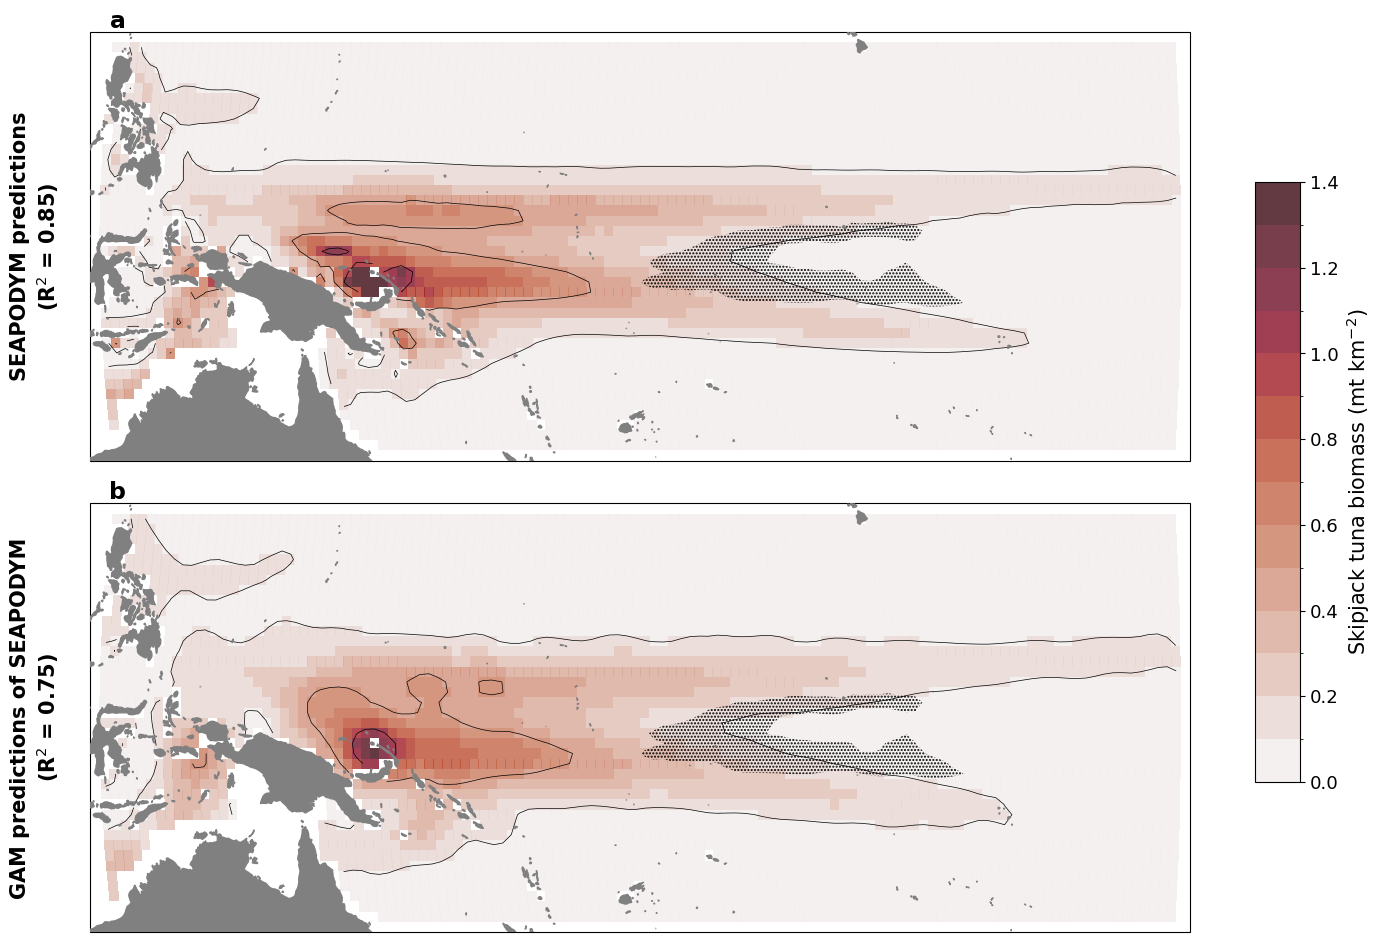

In [13]:
%%time

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.amp, 0.8)
levs = np.arange(0,1.5,0.1)
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = [0.1, 0.5, 1.0]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.5, 1.0]

fig = plt.figure(figsize=(15,10))
gs = GridSpec(2, 1)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)

p1 = ax1.pcolormesh(dat.coords['lon'], dat.coords['lat'], dat['actual_biomass'].mean(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax1.contour(dat.coords['lon'], dat.coords['lat'], dat['actual_biomass'].mean(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax1.contourf(dat.coords['lon'], dat.coords['lat'], r2_map[:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.pcolormesh(dat.coords['lon'], dat.coords['lat'], dat['predicted_biomass'].mean(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax2.contour(dat.coords['lon'], dat.coords['lat'], dat['predicted_biomass'].mean(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax2.contourf(dat.coords['lon'], dat.coords['lat'], r2_map[:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())


ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.91, 0.2, 0.03, 0.6])
cbar = plt.colorbar(p1, cax=cbax, orientation='vertical', ticks=levs[::2])
cbar.ax.set_ylabel("Skipjack tuna biomass (mt km$^{-2}$)", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.05; yy = 0.5
plt.text(xx, yy, 'SEAPODYM predictions\n(R$^{2}$ = 0.85)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'GAM predictions of SEAPODYM\n(R$^{2}$ = 0.75)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax2.transAxes)

lon1 = 119; lon2 = 241
lat1 = -21; lat2 = 21
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

xx = 0.025; yy = 1.025
plt.text(xx, yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx, yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)

plt.subplots_adjust(top=0.95, right=0.9, left=0.1, wspace=0.0, hspace=0.1, bottom=0.05)



In [103]:
os.chdir(wrkdir)
fig.savefig("./figures/skipjack_biomass_actual_and_predicted_climatology.png", dpi=300)
fig.savefig("./figures/skipjack_biomass_actual_and_predicted_climatology_transparent.png", dpi=300, transparent=True)


### actual and predicted biomass changes during 2015 El Nino

In [14]:
dat['time']

<xarray.DataArray 'time' (time: 210)> Size: 2kB
array(['2005-07-15T00:00:00.000000000', '2005-08-15T00:00:00.000000000',
       '2005-09-15T00:00:00.000000000', ..., '2022-10-15T00:00:00.000000000',
       '2022-11-15T00:00:00.000000000', '2022-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2005-07-15 2005-08-15 ... 2022-12-15

CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 109 ms


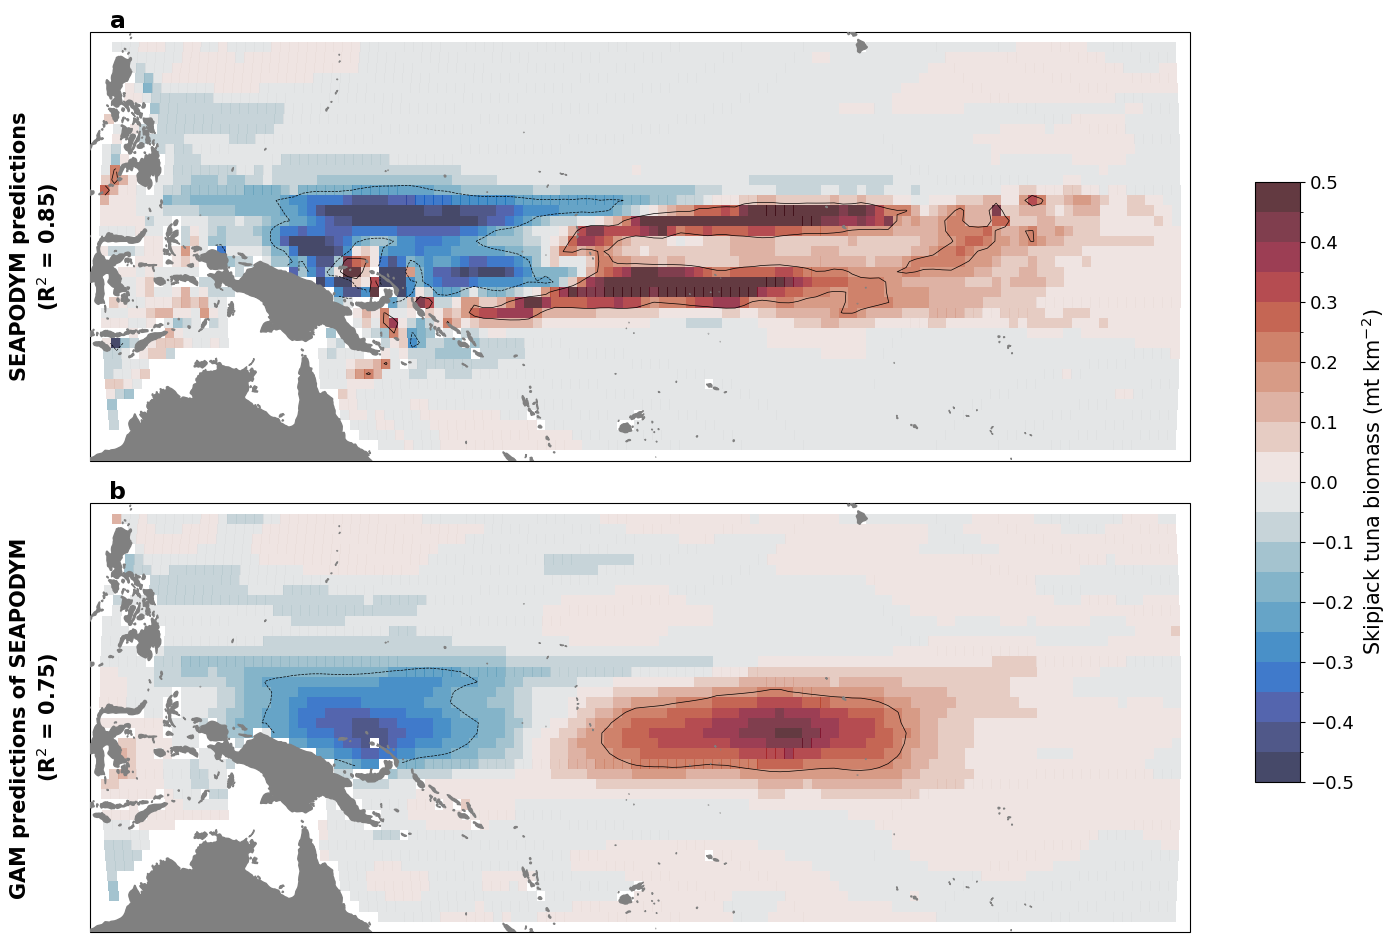

In [17]:
%%time

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-0.5,0.51,0.05)
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = [-0.2, 0.2]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.5, 1.0]

fig = plt.figure(figsize=(15,10))
gs = GridSpec(2, 1)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)

p1 = ax1.pcolormesh(dat.coords['lon'], dat.coords['lat'], dat['actual_biomass'].sel(time="2015-12-15", method='nearest') - dat['actual_biomass'].mean(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax1.contour(dat.coords['lon'], dat.coords['lat'], dat['actual_biomass'].sel(time="2015-12-15", method='nearest') - dat['actual_biomass'].mean(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p2 = ax2.pcolormesh(dat.coords['lon'], dat.coords['lat'], dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - dat['predicted_biomass'].mean(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax2.contour(dat.coords['lon'], dat.coords['lat'], dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - dat['predicted_biomass'].mean(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())


ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.91, 0.2, 0.03, 0.6])
cbar = plt.colorbar(p1, cax=cbax, orientation='vertical', ticks=levs[::2])
cbar.ax.set_ylabel("Skipjack tuna biomass (mt km$^{-2}$)", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.05; yy = 0.5
plt.text(xx, yy, 'SEAPODYM predictions\n(R$^{2}$ = 0.85)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'GAM predictions of SEAPODYM\n(R$^{2}$ = 0.75)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax2.transAxes)

lon1 = 119; lon2 = 241
lat1 = -21; lat2 = 21
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

xx = 0.025; yy = 1.025
plt.text(xx, yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx, yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)

plt.subplots_adjust(top=0.95, right=0.9, left=0.1, wspace=0.0, hspace=0.1, bottom=0.05)



In [18]:
os.chdir(wrkdir)
fig.savefig("./figures/skipjack_biomass_actual_and_predicted_2015ElNino.png", dpi=300)
fig.savefig("./figures/skipjack_biomass_actual_and_predicted_2015ElNino_transparent.png", dpi=300, transparent=True)


#### Plot the effects of different drivers

CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 242 ms


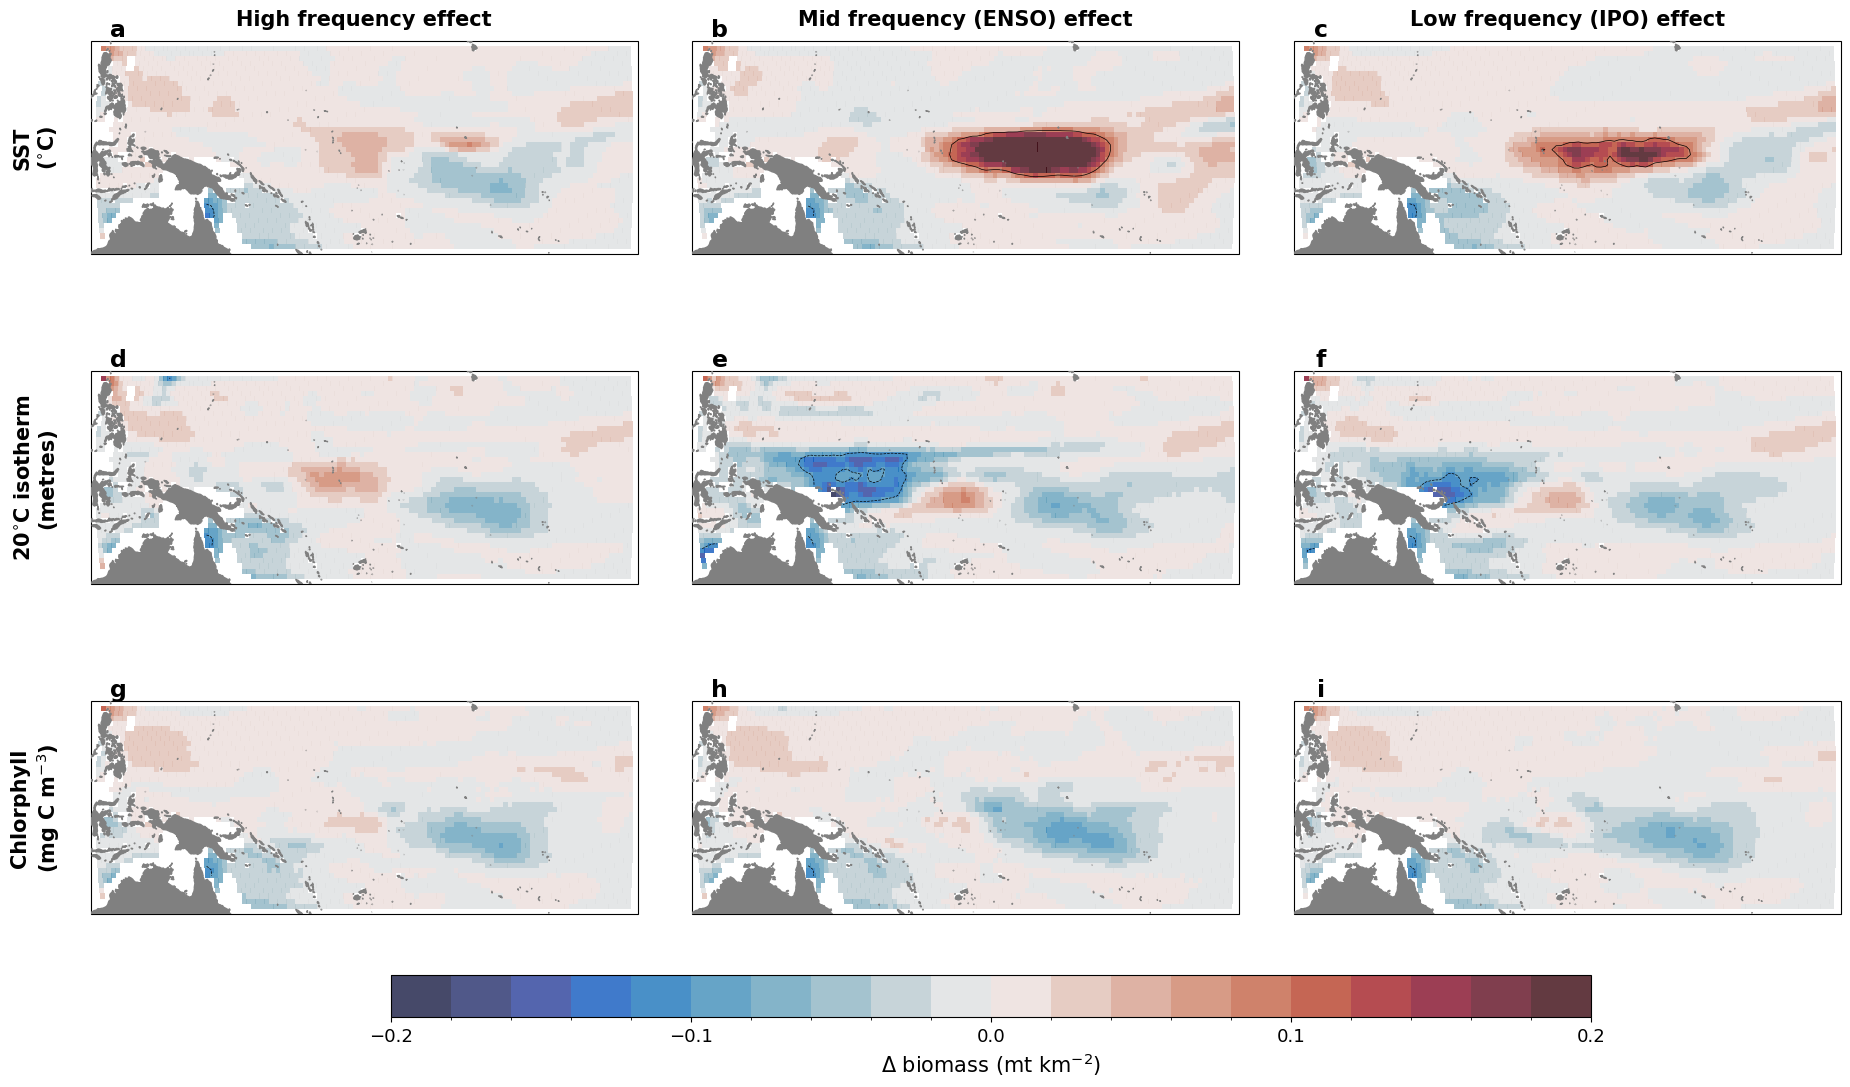

In [23]:
%%time

lons = dat.coords['lon'].values
lats = dat.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-20,21,2)*0.01
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = np.array([-10, 10])*0.01
#hatching = [' ', '.....']
#hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(20,12))
gs = GridSpec(3, 3)

ax1 = plt.subplot(gs[0,0], projection=proj)  # SST
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[1,0], projection=proj)  # lagSST
ax5 = plt.subplot(gs[1,1], projection=proj)
ax6 = plt.subplot(gs[1,2], projection=proj)
ax7 = plt.subplot(gs[2,0], projection=proj)  # z20
ax8 = plt.subplot(gs[2,1], projection=proj)
ax9 = plt.subplot(gs[2,2], projection=proj)

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_HF_sst'].sel(time="2015-12-15", method='nearest')
p1 = ax1.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax1.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_MF_sst'].sel(time="2015-12-15", method='nearest')
p2 = ax2.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax2.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_LF_sst'].sel(time="2015-12-15", method='nearest')
p3 = ax3.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax3.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_HF_z20'].sel(time="2015-12-15", method='nearest')
p4 = ax4.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax4.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_MF_z20'].sel(time="2015-12-15", method='nearest')
p5 = ax5.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax5.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_LF_z20'].sel(time="2015-12-15", method='nearest')
p6 = ax6.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax6.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_HF_chl'].sel(time="2015-12-15", method='nearest')
p7 = ax7.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax7.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_MF_chl'].sel(time="2015-12-15", method='nearest')
p8 = ax8.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax8.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

tmp = dat['predicted_biomass'].sel(time="2015-12-15", method='nearest') - scenarios['without_LF_chl'].sel(time="2015-12-15", method='nearest')
p9 = ax9.pcolormesh(lons, lats, tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax9.contour(lons, lats, tmp, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())


ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.2, 0.1, 0.6, 0.035])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("$\Delta$ biomass (mt km$^{-2}$)", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, '20$^{\circ}$C isotherm\n(metres)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax4.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax7.transAxes)

ax1.text(0.5, 1.1, 'High frequency effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'Mid frequency (ENSO) effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)
ax3.text(0.5, 1.1, 'Low frequency (IPO) effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax3.transAxes)

lon1 = 119; lon2 = 241
lat1 = -21; lat2 = 21
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax3.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax6.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax9.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

xx = 0.05; yy = 1.05
plt.text(xx, yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx, yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)
plt.text(xx, yy, "c", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax3.transAxes)
plt.text(xx, yy, "d", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax4.transAxes)
plt.text(xx, yy, "e", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax5.transAxes)
plt.text(xx, yy, "f", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax6.transAxes)
plt.text(xx, yy, "g", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax7.transAxes)
plt.text(xx, yy, "h", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax8.transAxes)
plt.text(xx, yy, "i", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax9.transAxes)


plt.subplots_adjust(top=0.95, right=0.925, left=0.05, wspace=0.1, hspace=0.1, bottom=0.15)



In [24]:
os.chdir(wrkdir)
fig.savefig("./figures/skipjack_biomass_predicted_2015ElNino_predictors.png", dpi=300)
fig.savefig("./figures/skipjack_biomass_predicted_2015ElNino_predictors_transparent.png", dpi=300, transparent=True)


#### plot the climate change trend on tuna biomass

CPU times: user 78.7 ms, sys: 22.2 ms, total: 101 ms
Wall time: 100 ms


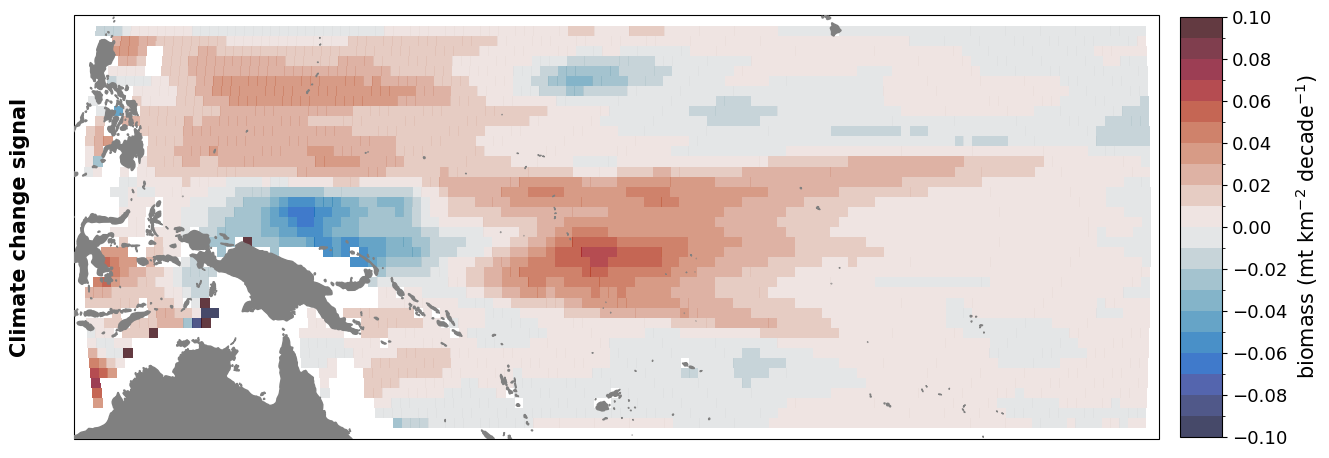

In [33]:
%%time

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-0.1,0.11,0.01)
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = [-0.05, 0.05]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.5, 1.0]

fig = plt.figure(figsize=(14,7))
gs = GridSpec(1, 1)

ax1 = plt.subplot(gs[0,0], projection=proj)

tmp = scenarios['with_CC'].diff(dim='time').mean(dim='time')*12*10
p1 = ax1.pcolormesh(dat.coords['lon'], dat.coords['lat'], tmp, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
#ax1.contour(dat.coords['lon'], dat.coords['lat'], dat['actual_biomass'].sel(time="2015-12-15", method='nearest') - dat['actual_biomass'].mean(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())


ax1.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.89, 0.2, 0.03, 0.6])
cbar = plt.colorbar(p1, cax=cbax, orientation='vertical', ticks=levs[::2])
cbar.ax.set_ylabel("biomass (mt km$^{-2}$ decade$^{-1}$)", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.05; yy = 0.5
plt.text(xx, yy, 'Climate change signal', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)

lon1 = 119; lon2 = 241
lat1 = -21; lat2 = 21
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

plt.subplots_adjust(top=0.95, right=0.875, left=0.1, wspace=0.0, hspace=0.1, bottom=0.05)



In [34]:
os.chdir(wrkdir)
fig.savefig("./figures/skipjack_biomass_predicted_CC.png", dpi=300)
fig.savefig("./figures/skipjack_biomass_predicted_CC_transparent.png", dpi=300, transparent=True)


### Visualise the effect of SST, z20 and Chl on Tuna biomass

#### How?
* Determine correlation between SST and biomass effect of SST, etc.

In [175]:
# Get effects of the predictors on the biomass
sst_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_sst']
sstlag6_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_sstlag6']
z20_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_z20']
chl_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_chl']
sstxy_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_sstxy']
sstlag6xy_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_sstlag6xy']
z20xy_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_z20xy']
chlxy_effect = dat['predicted_biomass'] - dat['predicted_biomass_no_chlxy']

sst_tmp = sst.where(sst_effect)['sst']
z20_tmp = z20.where(z20_effect)['z20']
chl_tmp = chl.where(chl_effect)['chlorophyll']

sst_effect_corr = xr.corr(sst_effect, sst_tmp, dim='time')
sstlag6_effect_corr = xr.corr(sstlag6_effect, sst_tmp, dim='time')
z20_effect_corr = xr.corr(z20_effect, z20_tmp, dim='time')
chl_effect_corr = xr.corr(chl_effect, chl_tmp, dim='time')
sstxy_effect_corr = xr.corr(sstxy_effect, sst_tmp, dim='time')
sstlag6xy_effect_corr = xr.corr(sstlag6xy_effect, sst_tmp, dim='time')
z20xy_effect_corr = xr.corr(z20xy_effect, z20_tmp, dim='time')
chlxy_effect_corr = xr.corr(chlxy_effect, chl_tmp, dim='time')


In [176]:
# Define the approximate latitude and longitude for each location
locations = {
    "Hawaii": [(18.5, -156.0+360.0)],
    "Kiribati": [(3.1, -171.5+360.0)],  # Multiple island groups
    "Nauru": [(-0.5, 166.9)],
    "Solomon Islands": [(-9.6, 161.0)],
    "Guam": [(13.4, 144.7)],
    "Tonga": [(-19.0, -174.8+360.0)]
}

In [191]:
# Extract the data
def extract_correlations(dataar, locations):
    """Extracts time series from a dataset given location coordinates."""
    data = {}
    
    for name, coords in locations.items():
        lat, lon = coords[0]
        
        # Find the closest grid point in the dataset
        ds_sel = dataar.sel(lat=lat, lon=lon, method="nearest")
        
        # Extract correlation
        corr = ds_sel.to_dataframe(name="effect")
        
        data[name] = corr
        
    return data

# Extract correlations
locations_sst = extract_correlations(sst_tmp, locations)
locations_z20 = extract_correlations(z20_tmp, locations)
locations_chl = extract_correlations(chl_tmp, locations)

locations_sst_effect = extract_correlations(sst_effect, locations)
locations_sstlag6_effect = extract_correlations(sstlag6_effect, locations)
locations_z20_effect = extract_correlations(z20_effect, locations)
locations_chl_effect = extract_correlations(chl_effect, locations)
locations_sstxy_effect = extract_correlations(sstxy_effect, locations)
locations_sstlag6xy_effect = extract_correlations(sstlag6xy_effect, locations)
locations_z20xy_effect = extract_correlations(z20xy_effect, locations)
locations_chlxy_effect = extract_correlations(chlxy_effect, locations)

# Extract the data
def extract_scalar_correlations(dataar, locations):
    """Extract scalar correlation values at specific locations."""
    data = {}

    for name, coords in locations.items():
        lat, lon = coords[0]

        # Select nearest grid point
        ds_sel = dataar.sel(lat=lat, lon=lon, method="nearest")

        try:
            # Extract scalar value
            value = ds_sel.item()
            data[name] = value
        except:
            print(f"Failed to extract value at {name} (lat={lat}, lon={lon})")
            data[name] = None  # or np.nan

    return data

locations_sst_corrs = extract_scalar_correlations(sst_effect_corr, locations)
locations_sstlag6_corrs = extract_scalar_correlations(sstlag6_effect_corr, locations)
locations_z20_corrs = extract_scalar_correlations(z20_effect_corr, locations)
locations_chl_corrs = extract_scalar_correlations(chl_effect_corr, locations)
locations_sstxy_corrs = extract_scalar_correlations(sstxy_effect_corr, locations)
locations_sstlag6xy_corrs = extract_scalar_correlations(sstlag6xy_effect_corr, locations)
locations_z20xy_corrs = extract_scalar_correlations(z20xy_effect_corr, locations)
locations_chlxy_corrs = extract_scalar_correlations(chlxy_effect_corr, locations)


In [192]:
print(locations_sst_corrs)
print(locations_z20_corrs)
print(locations_chl_corrs)

print(locations_sstxy_corrs)
print(locations_z20xy_corrs)
print(locations_chlxy_corrs)


{'Hawaii': 0.8346028923988342, 'Kiribati': 0.9855704307556152, 'Nauru': 0.9961990714073181, 'Solomon Islands': 0.9980830550193787, 'Guam': 0.9982773065567017, 'Tonga': 0.927647054195404}
{'Hawaii': 0.9992935446609029, 'Kiribati': 0.9987652654164798, 'Nauru': 0.9886522191162066, 'Solomon Islands': 0.9451135433348448, 'Guam': 0.9730990635321171, 'Tonga': 0.9129996589972923}
{'Hawaii': 0.9993128776550293, 'Kiribati': 0.9665813446044922, 'Nauru': 0.9587010741233826, 'Solomon Islands': 0.2521326243877411, 'Guam': 0.9623318910598755, 'Tonga': 0.9959628582000732}
{'Hawaii': -0.8363532423973083, 'Kiribati': 0.9976515769958496, 'Nauru': 0.9522173404693604, 'Solomon Islands': 0.3256080448627472, 'Guam': 0.8930175304412842, 'Tonga': -0.9358091354370117}
{'Hawaii': -0.9544716016796264, 'Kiribati': -0.19560353794238486, 'Nauru': 0.7964551151012967, 'Solomon Islands': -0.8403982923657596, 'Guam': -0.9275932356183306, 'Tonga': -0.31259113820620243}
{'Hawaii': -0.9765819311141968, 'Kiribati': 0.989148

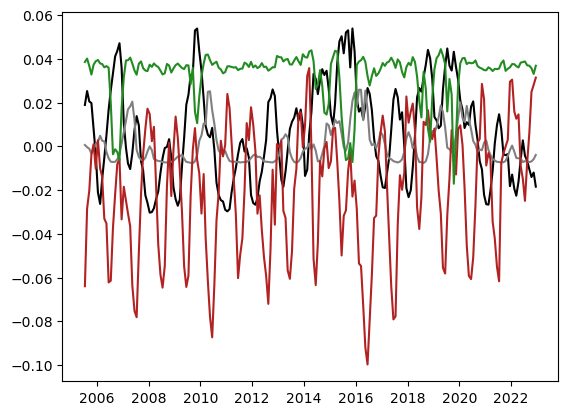

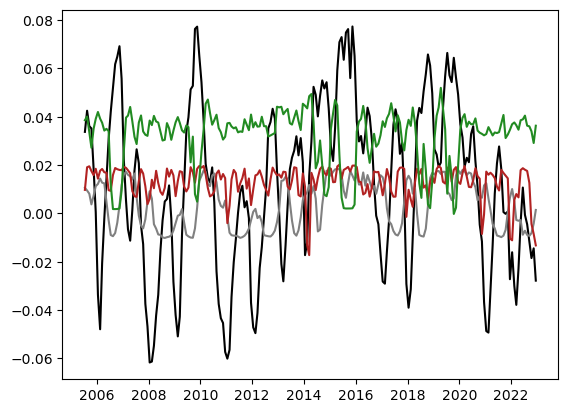

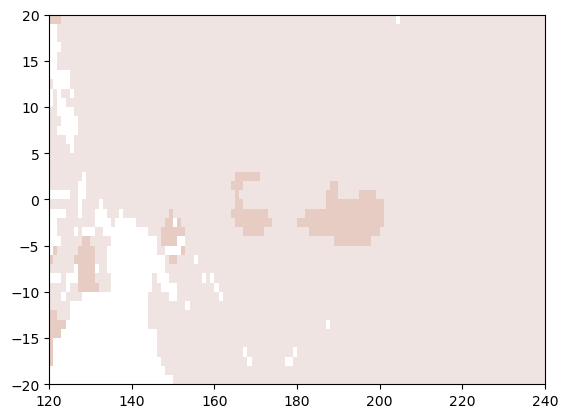

In [193]:
locations_sst_effect
plt.figure()
plt.plot(locations_sst_effect['Kiribati']['effect'], color='k')
plt.plot(locations_sstlag6_effect['Kiribati']['effect'], color='grey')
plt.plot(locations_z20_effect['Kiribati']['effect'], color='firebrick')
plt.plot(locations_chl_effect['Kiribati']['effect'], color='forestgreen')

plt.figure()
plt.plot(locations_sstxy_effect['Kiribati']['effect'], color='k')
plt.plot(locations_sstlag6xy_effect['Kiribati']['effect'], color='grey')
plt.plot(locations_z20xy_effect['Kiribati']['effect'], color='firebrick')
plt.plot(locations_chlxy_effect['Kiribati']['effect'], color='forestgreen')

plt.figure()
plt.pcolormesh(lons, lats, sst_effect.max(dim='time') - sst_effect.min(dim='time'), cmap=colmap, norm=norm)



#### Plot the effects

CPU times: user 626 ms, sys: 3.07 ms, total: 629 ms
Wall time: 627 ms


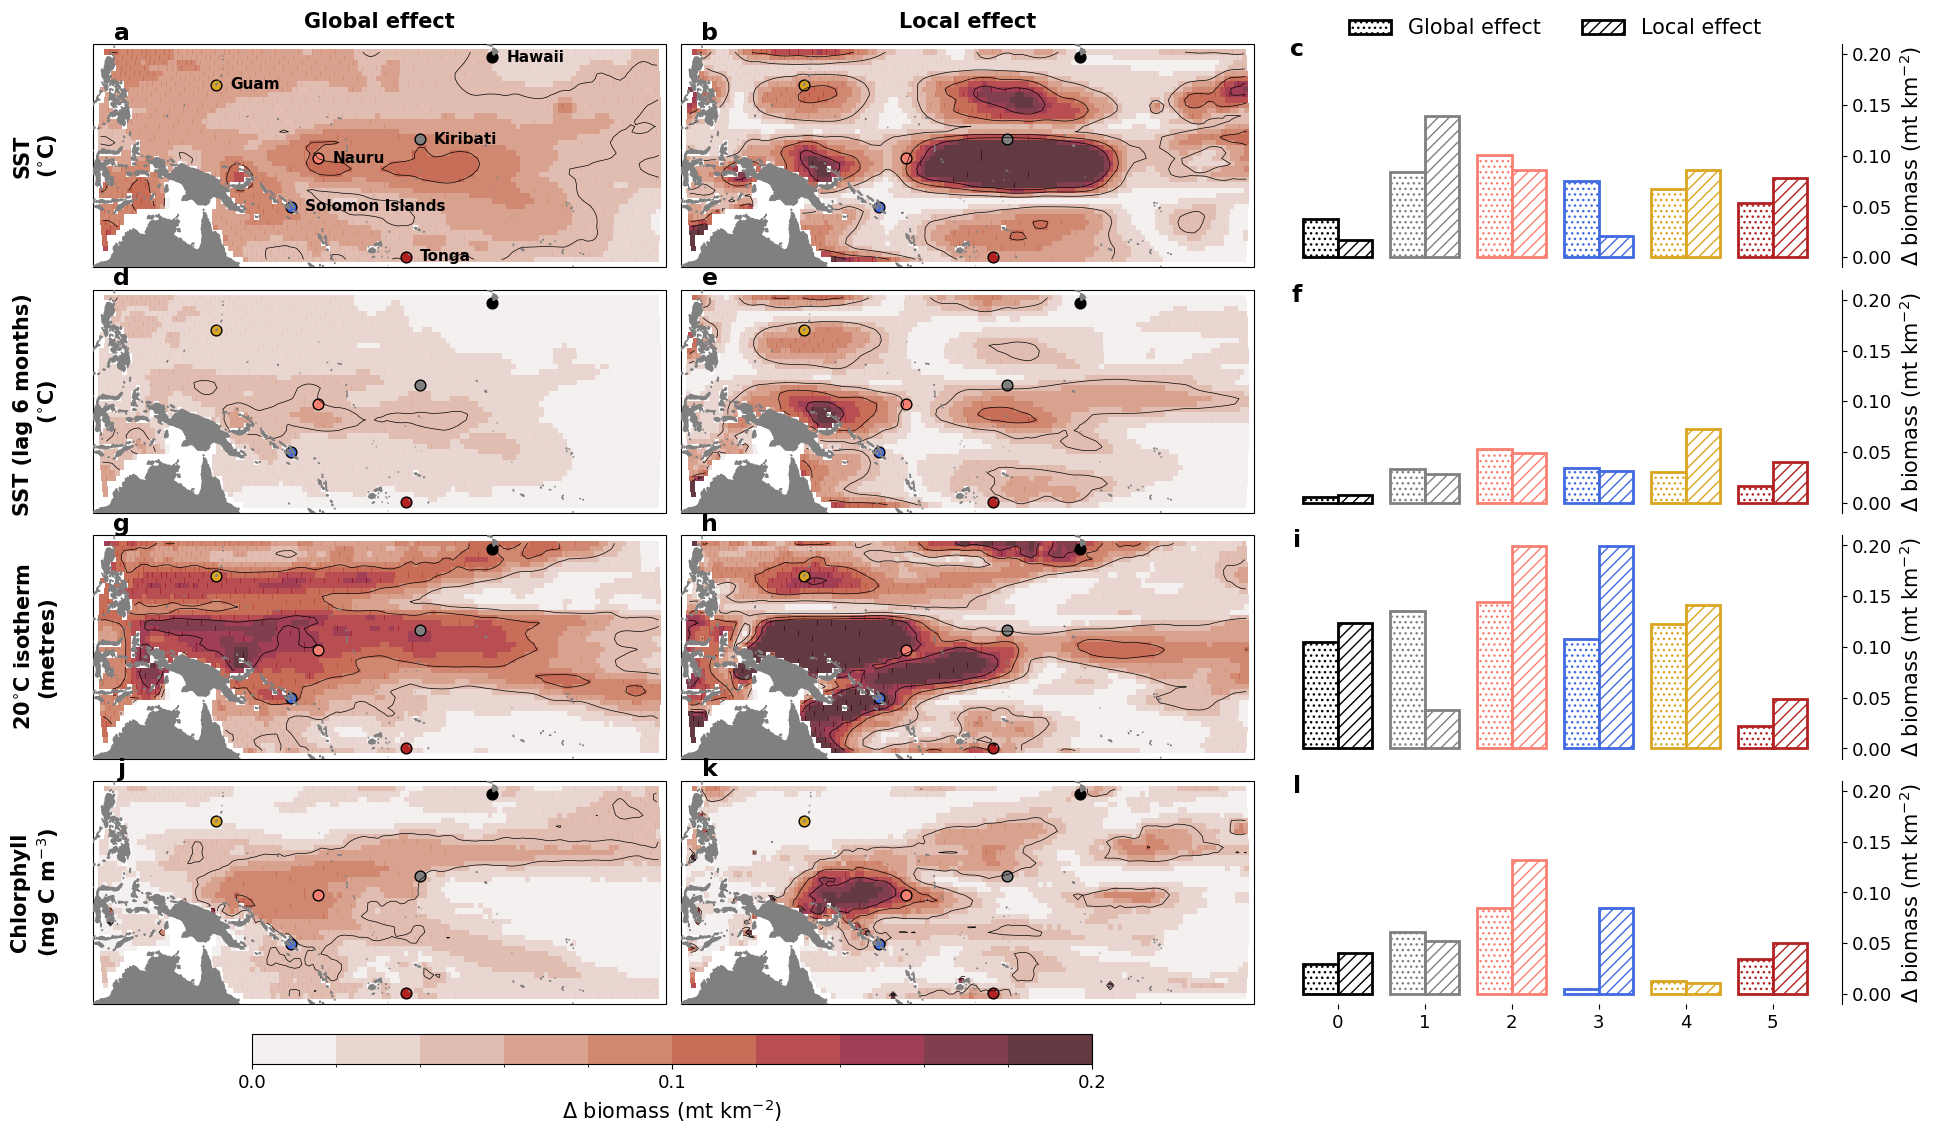

In [194]:
%%time

lons = dat.coords['lon'].values
lats = dat.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.amp, 0.8)
levs = np.arange(0,21,2)*0.01
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = np.array([5, 10, 15])*0.01
#hatching = [' ', '.....']
#hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(20,12))
gs = GridSpec(4, 12)

ax1 = plt.subplot(gs[0,0:4], projection=proj)  # SST
ax2 = plt.subplot(gs[0,4:8], projection=proj)
ax3 = plt.subplot(gs[0,8:12])
ax4 = plt.subplot(gs[1,0:4], projection=proj)  # lagSST
ax5 = plt.subplot(gs[1,4:8], projection=proj)
ax6 = plt.subplot(gs[1,8:12])
ax7 = plt.subplot(gs[2,0:4], projection=proj)  # z20
ax8 = plt.subplot(gs[2,4:8], projection=proj)
ax9 = plt.subplot(gs[2,8:12])
ax10 = plt.subplot(gs[3,0:4], projection=proj)  # chl
ax11 = plt.subplot(gs[3,4:8], projection=proj)
ax12 = plt.subplot(gs[3,8:12])

p1 = ax1.pcolormesh(lons, lats, sst_effect.max(dim='time') - sst_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax1.contour(lons, lats, sst_effect.max(dim='time') - sst_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax1.contourf(lons, lats, sst_effect.max(dim='time') - sst_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.pcolormesh(lons, lats, sstxy_effect.max(dim='time') - sstxy_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax2.contour(lons, lats, sstxy_effect.max(dim='time') - sstxy_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax2.contourf(lons, lats, sstxy_effect.max(dim='time') - sstxy_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p4 = ax4.pcolormesh(lons, lats, sstlag6_effect.max(dim='time') - sstlag6_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax4.contour(lons, lats, sstlag6_effect.max(dim='time') - sstlag6_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax4.contourf(lons, lats, sstlag6_effect.max(dim='time') - sstlag6_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p5 = ax5.pcolormesh(lons, lats, sstlag6xy_effect.max(dim='time') - sstlag6xy_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax5.contour(lons, lats, sstlag6xy_effect.max(dim='time') - sstlag6xy_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax5.contourf(lons, lats, sstlag6xy_effect.max(dim='time') - sstlag6xy_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p7 = ax7.pcolormesh(lons, lats, z20_effect.max(dim='time') - z20_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax7.contour(lons, lats, z20_effect.max(dim='time') - z20_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax7.contourf(lons, lats, z20_effect.max(dim='time') - z20_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p8 = ax8.pcolormesh(lons, lats, z20xy_effect.max(dim='time') - z20xy_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax8.contour(lons, lats, z20xy_effect.max(dim='time') - z20xy_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax8.contourf(lons, lats, z20xy_effect.max(dim='time') - z20xy_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p10 = ax10.pcolormesh(lons, lats, chl_effect.max(dim='time') - chl_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax10.contour(lons, lats, chl_effect.max(dim='time') - chl_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax10.contourf(lons, lats, chl_effect.max(dim='time') - chl_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p11 = ax11.pcolormesh(lons, lats, chlxy_effect.max(dim='time') - chlxy_effect.min(dim='time'), cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax11.contour(lons, lats, chlxy_effect.max(dim='time') - chlxy_effect.min(dim='time'), colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
#ax11.contourf(lons, lats, chlxy_effect.max(dim='time') - chlxy_effect.min(dim='time'), colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())


# Add scatter points showing correlations to far right panels
cols = ['k', 'grey', 'salmon', 'royalblue', 'goldenrod', 'firebrick']
hatc = ['...', '///']
ii = 0
for name, coords in locations.items():
    if ii == 0:
        ax3.bar(ii-0.2, locations_sst_effect[name]['effect'].max() - locations_sst_effect[name]['effect'].min(), color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, label="Global effect", width=0.4)
        ax3.bar(ii+0.2, locations_sstxy_effect[name]['effect'].max() - locations_sstxy_effect[name]['effect'].min(), color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, label="Local effect", width=0.4)
    else:
        ax3.bar(ii-0.2, locations_sst_effect[name]['effect'].max() - locations_sst_effect[name]['effect'].min(), color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
        ax3.bar(ii+0.2, locations_sstxy_effect[name]['effect'].max() - locations_sstxy_effect[name]['effect'].min(), color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax6.bar(ii-0.2, locations_sstlag6_effect[name]['effect'].max() - locations_sstlag6_effect[name]['effect'].min(), color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax6.bar(ii+0.2, locations_sstlag6xy_effect[name]['effect'].max() - locations_sstlag6xy_effect[name]['effect'].min(), color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax9.bar(ii-0.2, locations_z20_effect[name]['effect'].max() - locations_z20_effect[name]['effect'].min(), color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax9.bar(ii+0.2, locations_z20xy_effect[name]['effect'].max() - locations_z20xy_effect[name]['effect'].min(), color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax12.bar(ii-0.2, locations_chl_effect[name]['effect'].max() - locations_chl_effect[name]['effect'].min(), color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax12.bar(ii+0.2, locations_chlxy_effect[name]['effect'].max() - locations_chlxy_effect[name]['effect'].min(), color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ii += 1

ii = 0
# Add location points to the map
for name, coords in locations.items():
    lat, lon = coords[0]
    ax1.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax1.text(lon + 3, lat, name, fontsize=fstic-2, transform=ccrs.PlateCarree(), ha='left', va='center', fontweight='bold')
    ax2.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax4.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax5.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax7.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax8.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax10.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax11.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ii += 1

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.13, 0.1, 0.42, 0.025])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("$\Delta$ biomass (mt km$^{-2}$)", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'SST (lag 6 months) \n($^{\circ}$C)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax4.transAxes)
plt.text(xx, yy, '20$^{\circ}$C isotherm\n(metres)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax10.transAxes)

ax1.text(0.5, 1.1, 'Global effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'Local effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)

lon1 = 119; lon2 = 241
lat1 = -21; lat2 = 21
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

xx = 0.05; yy = 1.05
plt.text(xx, yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx, yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)
plt.text(xx, yy-0.075, "c", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax3.transAxes)
plt.text(xx, yy, "d", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax4.transAxes)
plt.text(xx, yy, "e", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax5.transAxes)
plt.text(xx, yy-0.075, "f", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax6.transAxes)
plt.text(xx, yy, "g", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax7.transAxes)
plt.text(xx, yy, "h", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax8.transAxes)
plt.text(xx, yy-0.075, "i", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax9.transAxes)
plt.text(xx, yy, "j", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax10.transAxes)
plt.text(xx, yy, "k", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax11.transAxes)
plt.text(xx, yy-0.075, "l", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax12.transAxes)

ax3.spines[['top', 'left', 'bottom']].set_visible(False)
ax6.spines[['top', 'left', 'bottom']].set_visible(False)
ax9.spines[['top', 'left', 'bottom']].set_visible(False)
ax12.spines[['top', 'left', 'bottom']].set_visible(False)

ax3.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax6.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax9.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax12.tick_params(labelsize=fstic, left=False, labelleft=False, right=True, labelright=True)

ax3.set_ylim(-0.01,0.21)
ax6.set_ylim(-0.01,0.21)
ax9.set_ylim(-0.01,0.21)
ax12.set_ylim(-0.01,0.21)

ax3.set_ylabel("$\Delta$ biomass (mt km$^{-2}$)", fontsize=fslab)
ax6.set_ylabel("$\Delta$ biomass (mt km$^{-2}$)", fontsize=fslab)
ax9.set_ylabel("$\Delta$ biomass (mt km$^{-2}$)", fontsize=fslab)
ax12.set_ylabel("$\Delta$ biomass (mt km$^{-2}$)", fontsize=fslab)

ax3.yaxis.set_label_position('right')
ax6.yaxis.set_label_position('right')
ax9.yaxis.set_label_position('right')
ax12.yaxis.set_label_position('right')

ax3.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax3.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax6.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax6.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax9.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax9.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax12.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax12.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')

ax3.legend(frameon=False, loc='upper center', ncols=2, fontsize=fslab, bbox_to_anchor=(0.5,1.2))

plt.subplots_adjust(top=0.95, right=0.925, left=0.05, wspace=0.1, hspace=0.1, bottom=0.15)



In [185]:
os.chdir(wrkdir)
fig.savefig("./figures/skipjack_biomass_variable_effects.png", dpi=300)
fig.savefig("./figures/skipjack_biomass_variable_effects_transparent.png", dpi=300, transparent=True)


#### Plot correlations

In [189]:
locations_sst_corrs

{'Hawaii': 0.8346028923988342,
 'Kiribati': 0.9855704307556152,
 'Nauru': 0.9961990714073181,
 'Solomon Islands': 0.9980830550193787,
 'Guam': 0.9982773065567017,
 'Tonga': 0.927647054195404}

CPU times: user 496 ms, sys: 4.84 ms, total: 501 ms
Wall time: 499 ms


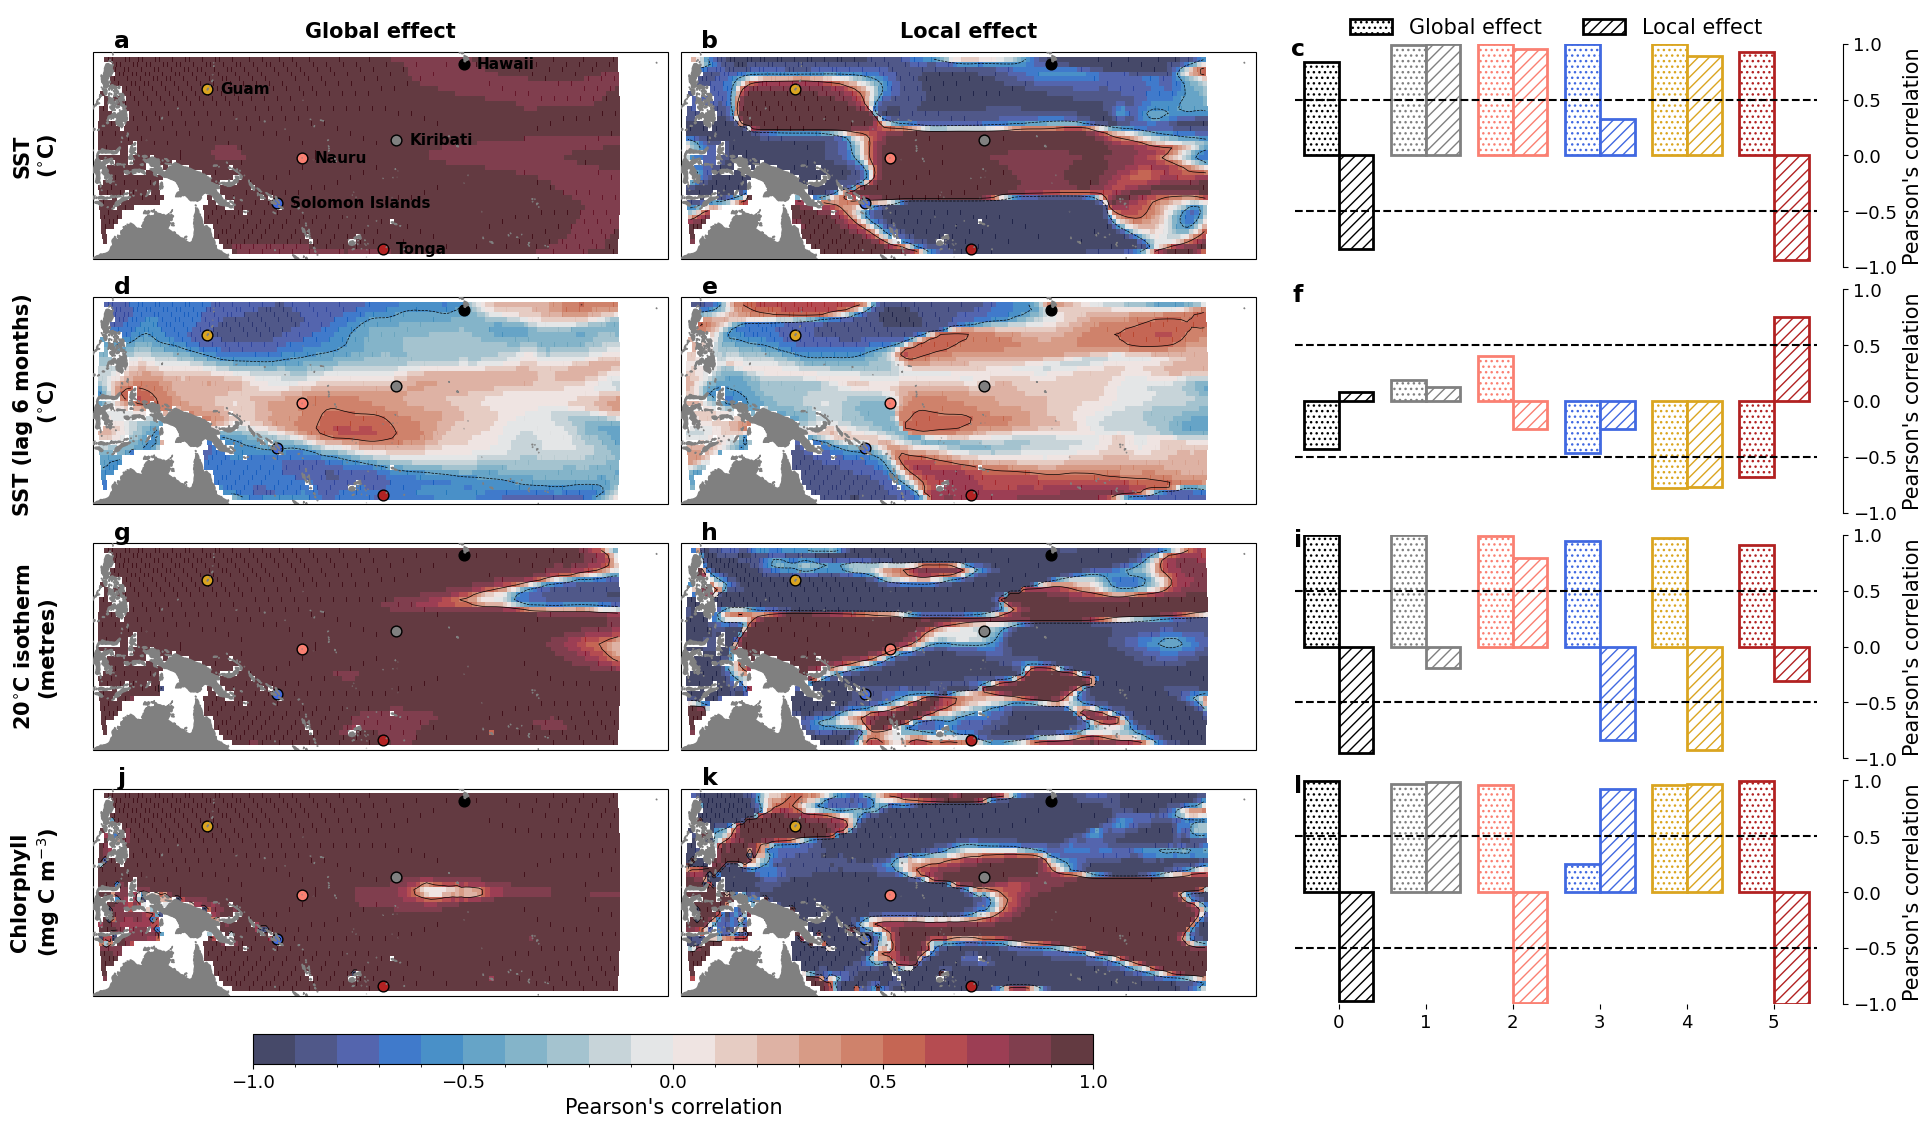

In [196]:
%%time

lons = dat.coords['lon'].values
lats = dat.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-10,11,1)*0.1
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = np.array([-5, 5])*0.1
#hatching = [' ', '.....']
#hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(20,12))
gs = GridSpec(4, 12)

ax1 = plt.subplot(gs[0,0:4], projection=proj)  # SST
ax2 = plt.subplot(gs[0,4:8], projection=proj)
ax3 = plt.subplot(gs[0,8:12])
ax4 = plt.subplot(gs[1,0:4], projection=proj)  # lagSST
ax5 = plt.subplot(gs[1,4:8], projection=proj)
ax6 = plt.subplot(gs[1,8:12])
ax7 = plt.subplot(gs[2,0:4], projection=proj)  # z20
ax8 = plt.subplot(gs[2,4:8], projection=proj)
ax9 = plt.subplot(gs[2,8:12])
ax10 = plt.subplot(gs[3,0:4], projection=proj)  # chl
ax11 = plt.subplot(gs[3,4:8], projection=proj)
ax12 = plt.subplot(gs[3,8:12])

p1 = ax1.pcolormesh(lons, lats, sst_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax1.contour(lons, lats, sst_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p2 = ax2.pcolormesh(lons, lats, sstxy_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax2.contour(lons, lats, sstxy_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p4 = ax4.pcolormesh(lons, lats, sstlag6_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax4.contour(lons, lats, sstlag6_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p5 = ax5.pcolormesh(lons, lats, sstlag6xy_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax5.contour(lons, lats, sstlag6xy_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p7 = ax7.pcolormesh(lons, lats, z20_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax7.contour(lons, lats, z20_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p8 = ax8.pcolormesh(lons, lats, z20xy_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax8.contour(lons, lats, z20xy_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p10 = ax10.pcolormesh(lons, lats, chl_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax10.contour(lons, lats, chl_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())

p11 = ax11.pcolormesh(lons, lats, chlxy_effect_corr, cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax11.contour(lons, lats, chlxy_effect_corr, colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())


# Add scatter points showing correlations to far right panels
cols = ['k', 'grey', 'salmon', 'royalblue', 'goldenrod', 'firebrick']
hatc = ['...', '///']
ii = 0
for name, coords in locations.items():
    if ii == 0:
        ax3.bar(ii-0.2, locations_sst_corrs[name], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, label="Global effect", width=0.4)
        ax3.bar(ii+0.2, locations_sstxy_corrs[name], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, label="Local effect", width=0.4)
    else:
        ax3.bar(ii-0.2, locations_sst_corrs[name], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
        ax3.bar(ii+0.2, locations_sstxy_corrs[name], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax6.bar(ii-0.2, locations_sstlag6_corrs[name],  color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax6.bar(ii+0.2, locations_sstlag6xy_corrs[name], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax9.bar(ii-0.2, locations_z20_corrs[name], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax9.bar(ii+0.2, locations_z20xy_corrs[name], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax12.bar(ii-0.2, locations_chl_corrs[name], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax12.bar(ii+0.2, locations_chlxy_corrs[name], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ii += 1

ii = 0
# Add location points to the map
for name, coords in locations.items():
    lat, lon = coords[0]
    ax1.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax1.text(lon + 3, lat, name, fontsize=fstic-2, transform=ccrs.PlateCarree(), ha='left', va='center', fontweight='bold')
    ax2.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax4.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax5.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax7.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax8.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax10.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax11.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ii += 1

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.13, 0.1, 0.42, 0.025])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("Pearson's correlation", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'SST (lag 6 months) \n($^{\circ}$C)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax4.transAxes)
plt.text(xx, yy, '20$^{\circ}$C isotherm\n(metres)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax10.transAxes)

ax1.text(0.5, 1.1, 'Global effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'Local effect', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)

lon1 = 119; lon2 = 251
lat1 = -21; lat2 = 21
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

xx = 0.05; yy = 1.05
plt.text(xx, yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx, yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)
plt.text(xx, yy-0.075, "c", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax3.transAxes)
plt.text(xx, yy, "d", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax4.transAxes)
plt.text(xx, yy, "e", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax5.transAxes)
plt.text(xx, yy-0.075, "f", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax6.transAxes)
plt.text(xx, yy, "g", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax7.transAxes)
plt.text(xx, yy, "h", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax8.transAxes)
plt.text(xx, yy-0.075, "i", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax9.transAxes)
plt.text(xx, yy, "j", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax10.transAxes)
plt.text(xx, yy, "k", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax11.transAxes)
plt.text(xx, yy-0.075, "l", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax12.transAxes)

ax3.spines[['top', 'left', 'bottom']].set_visible(False)
ax6.spines[['top', 'left', 'bottom']].set_visible(False)
ax9.spines[['top', 'left', 'bottom']].set_visible(False)
ax12.spines[['top', 'left', 'bottom']].set_visible(False)

ax3.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax6.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax9.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax12.tick_params(labelsize=fstic, left=False, labelleft=False, right=True, labelright=True)

ax3.set_ylim(-1,1)
ax6.set_ylim(-1,1)
ax9.set_ylim(-1,1)
ax12.set_ylim(-1,1)

ax3.set_ylabel("Pearson's correlation", fontsize=fslab)
ax6.set_ylabel("Pearson's correlation", fontsize=fslab)
ax9.set_ylabel("Pearson's correlation", fontsize=fslab)
ax12.set_ylabel("Pearson's correlation", fontsize=fslab)

ax3.yaxis.set_label_position('right')
ax6.yaxis.set_label_position('right')
ax9.yaxis.set_label_position('right')
ax12.yaxis.set_label_position('right')

ax3.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax3.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax6.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax6.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax9.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax9.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax12.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax12.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')

ax3.legend(frameon=False, loc='upper center', ncols=2, fontsize=fslab, bbox_to_anchor=(0.5,1.2))

plt.subplots_adjust(top=0.95, right=0.925, left=0.05, wspace=0.1, hspace=0.1, bottom=0.15)

